# Package Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/K-Water/Daejeon')
os.getcwd()

'/content/drive/MyDrive/K-Water/Daejeon'

In [3]:
%pip install xmltodict

# Packages Import
import numpy as np
import pandas as pd
import requests
import xmltodict

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 댐 / 하천 / 강수량 정보

```
@ 댐 정보
- 3008110 / 대청댐

@ 하천 정보
- 3009675 / 대전시(대덕대교)
- 3009673 / 대전시(한밭대교)
- 3009665 / 대전시(가수원교)
- 3009693 / 대전시(신구교)
- 3009670 / 대전시(만년교)
- 3009680 / 대전시(원촌교)
- 3009640 / 대전시(인창교)

@ 강수량 정보
- 30094040 / 대전시(만년교)
- 30094020 / 대전시(원촌교)
- 30094050 / 대전시(인창교)
```

# 댐 / 수위 / 강수량 10분 단위 API 호출 함수 생성
- 서비스키 : `6B5DF4EC-3167-43C1-88F4-D6F635E894B6`

## 댐 Data

### 댐 10분 단위 Data
- 변수
  - dmobscd :	댐 관측소 코드
  - ecpc : 	공용량(단위 : 백만 $ m^3 $)
  - inf : 유입량 (단위 : $ m^3/s $)
  - sfw : 저수량 (단위 : 만 $ m^3/s $)
  - tototf : 총 방류량 (단위 : $ m^3/s $)
  - ymdhm : 년월일시분

In [4]:
def dam_10(dam_code, start_ymd, end_ymd) :
  
  ### 서비스 URL
  url = "http://api.hrfco.go.kr"

  ### API Key
  serviceKey = "6B5DF4EC-3167-43C1-88F4-D6F635E894B6"

  ### 팔당댐 Code
  dam_cd = dam_code

  ### 기간
  time = start_ymd + "0000" + "/" + end_ymd + "2350"

  ### URL 생성
  data_url = url + "/" + serviceKey + "/" + "dam/list/10M/" + dam_cd + '/' + time

  ### XML 파일 읽기
  data_xml = requests.get(data_url)

  ### Encoding
  data_xml.encoding = 'utf8'

  ### Text 추출
  data_str = data_xml.text

  ### XML to dictionary
  data_dic = xmltodict.parse(data_str)
  
  ### dictionary에서 자료(item) 추출
  data_item = data_dic['entities']['content']['Dam']

  ### DataFrame 저장
  data_df = pd.DataFrame(data_item)
  return(data_df)

### 댐 관측소 제원
- 변수
  - addr : 주소
  - agcnm : 관할 부서
  - dmobscd : 댐 관측소 코드
  - etcaddr : 나머지 주소
  - fldlmtwl : 제한수위 (단위:El.m)
  - lat : 경도
  - lon : 위도
  - obsnm : 댐 관측소 명칭
  - pfh : 계획홍수위(단위 : m)


In [5]:
def dam_info(region) :
  ### 서비스 URL
  url = "http://api.hrfco.go.kr"

  ### API Key
  serviceKey = "6B5DF4EC-3167-43C1-88F4-D6F635E894B6"

  ### URL 생성
  data_url = url + "/" + serviceKey + "/dam/info"

  ### XML 파일 읽기
  data_xml = requests.get(data_url)

  ### Encoding
  data_xml.encoding = 'utf8'

  ### Text 추출
  data_str = data_xml.text

  ### XML to dictionary
  data_dic = xmltodict.parse(data_str)
  
  ### dictionary에서 자료(item) 추출
  data_item = data_dic['entities']['content']['Dam']

  ### DataFrame 저장
  data_df = pd.DataFrame(data_item)

  dam_info = data_df[(data_df['obsnm'] == region)]
  return(dam_info)

### 댐 Data Merge

In [6]:
def dam(dam_code, start_ymd, end_ymd, region) :
  # 댐 10분 단위 데이터
  data_dam = dam_10(dam_code, start_ymd, end_ymd)

  # 댐 관측소 정보 데이터 merge
  data_d = pd.merge(data_dam, dam_info(region), on = "dmobscd").copy()
  data_d.set_index("ymdhm", inplace = True)
  data_d = data_d[["obsnm", "dmobscd", "ecpc", "inf", "sfw", "tototf", "fldlmtwl", "addr", "etcaddr", "lat", "lon"]].copy()
  return(data_d)

## 수위 Data

### 수위 10분 단위 Data
- 변수
  - fw : 유량자료 (단위 : $ m^3/s $)
  - wl : 수위자료 (단위 : $ m $)
  - wlobscd : 수위 관측소 코드
  - ymdhm : 년월일시분

In [7]:
def wl_10(river_code, start_ymd, end_ymd) :
  
  ### 서비스 URL
  url = "http://api.hrfco.go.kr"

  ### API Key
  serviceKey = "6B5DF4EC-3167-43C1-88F4-D6F635E894B6"

  ### 중랑천/탄천 Code
  river_cd = river_code

  ### 기간
  time = start_ymd + "0000" + "/" + end_ymd + "2350"

  ### URL 생성
  data_url = url + "/" + serviceKey + "/" + "waterlevel/list/10M/" + river_cd + '/' + time

  ### XML 파일 읽기
  data_xml = requests.get(data_url)

  ### Encoding
  data_xml.encoding = 'utf8'

  ### Text 추출
  data_str = data_xml.text

  ### XML to dictionary
  data_dic = xmltodict.parse(data_str)
  
  ### dictionary에서 자료(item) 추출
  data_item = data_dic['entities']['content']['Waterlevel']

  ### DataFrame 저장
  data_df = pd.DataFrame(data_item)
  return(data_df)

### 수위 관측소 제원
- 변수
  - addr : 주소
  - agcnm : 관할 부서
  - almvl : 경보 수위(단위 : m)
  - attwl : 관심 수위(단위 : m)
  - etcaddr : 나머지 주소
  - fstnyn : 특보지점여부(Y/N)
  - gdt : 영점표고(단위 : EL.m)
  - lat : 경도
  - lon : 위도
  - obsnm : 수위 관측소 명칭
  - pfh : 계획홍수위(단위 : m)
  - srswl : 심각 수위(단위 : m)
  - wlobscd : 수위 관측소 코드
  - wrnwl : 주위보 수위(단위 : m)

In [8]:
def wl_info(region) :
  ### 서비스 URL
  url = "http://api.hrfco.go.kr"

  ### API Key
  serviceKey = "6B5DF4EC-3167-43C1-88F4-D6F635E894B6"

  ### URL 생성
  data_url = url + "/" + serviceKey + "/waterlevel/info"

  ### XML 파일 읽기
  data_xml = requests.get(data_url)

  ### Encoding
  data_xml.encoding = 'utf8'

  ### Text 추출
  data_str = data_xml.text

  ### XML to dictionary
  data_dic = xmltodict.parse(data_str)

  ### dictionary에서 자료(item) 추출
  data_item = data_dic['entities']['content']['WaterlevelInfo']

  ### DataFrame 저장
  data_df = pd.DataFrame(data_item)

  waterlevel_info = data_df[(data_df['obsnm'] == region)]
  return(waterlevel_info)

### 수위 Data Merge

In [9]:
def wl(river_code, start_ymd, end_ymd, region) :
  # 수위 10분 단위 데이터
  data_wl = wl_10(river_code, start_ymd, end_ymd)

  # 수위 관측소 정보 데이터 merge
  data_w = pd.merge(data_wl, wl_info(region), on = "wlobscd").copy()
  data_w.set_index("ymdhm", inplace = True)
  data_w = data_w[["obsnm", "wlobscd", "fw", "wl", "addr", "etcaddr", "fstnyn", "attwl", "wrnwl", "almwl", "srswl", "lat", "lon"]].copy()
  return(data_w)

## 강수량 Data

### 강수량 10분 단위 Data
- 변수
  - rf : 강수량자료 (단위 : $ mm $)
  - rfobscd : 수위 관측소 코드
  - ymdhm : 년월일시분

In [10]:
def rf_10(river_code, start_ymd, end_ymd) :
  
  ### 서비스 URL
  url = "http://api.hrfco.go.kr"

  ### API Key
  serviceKey = "6B5DF4EC-3167-43C1-88F4-D6F635E894B6"

  ### 중랑천/탄천 Code
  river_cd = river_code

  ### 기간
  time = start_ymd + "0000" + "/" + end_ymd + "2350"

  ### URL 생성
  data_url = url + "/" + serviceKey + "/" + "rainfall/list/10M/" + river_cd + '/' + time

  ### XML 파일 읽기
  data_xml = requests.get(data_url)

  ### Encoding
  data_xml.encoding = 'utf8'

  ### Text 추출
  data_str = data_xml.text

  ### XML to dictionary
  data_dic = xmltodict.parse(data_str)
  
  ### dictionary에서 자료(item) 추출
  data_item = data_dic['entities']['content']['Rainfall']

  ### DataFrame 저장
  data_df = pd.DataFrame(data_item)
  return(data_df)

### 강수량 관측소 제원
- 변수
  - addr : 주소
  - agcnm : 관할 부서
  - etcaddr : 나머지 주소
  - lat : 경도
  - lon : 위도
  - obsnm : 강수량 관측소 명칭
  - rfobscd : 강수량 관측소 코드

In [11]:
def rf_info(region) :
  ### 서비스 URL
  url = "http://api.hrfco.go.kr"

  ### API Key
  serviceKey = "6B5DF4EC-3167-43C1-88F4-D6F635E894B6"

  ### URL 생성
  data_url = url + "/" + serviceKey + "/rainfall/info"

  ### XML 파일 읽기
  data_xml = requests.get(data_url)

  ### Encoding
  data_xml.encoding = 'utf8'

  ### Text 추출
  data_str = data_xml.text

  ### XML to dictionary
  data_dic = xmltodict.parse(data_str)

  ### dictionary에서 자료(item) 추출
  data_item = data_dic['entities']['content']['Rainfall']

  ### DataFrame 저장
  data_df = pd.DataFrame(data_item)
  
  rainfall_info = data_df[(data_df['obsnm'] == region)]
  return(rainfall_info)

### 강수량 Data Merge

In [12]:
def rf(river_code, start_ymd, end_ymd, region) :
  # 강수량 10분 단위 데이터
  data_rf = rf_10(river_code, start_ymd, end_ymd)

  # 강수량 관측소 정보 데이터 merge
  data_r = pd.merge(data_rf, rf_info(region), on = "rfobscd").copy()
  data_r.set_index("ymdhm", inplace = True)
  data_r = data_r[["obsnm", "rfobscd", "rf", "addr", "etcaddr", "lat", "lon"]].copy()
  return(data_r)

# 댐 / 수위 / 강수량 Data 호출

- `for`문을 통해 1달마다의 Data를 따로 호출하는 이유 : 분당 1000건 이상 호출 불가능하기 때문

In [13]:
from datetime import datetime
from tqdm import tqdm
import calendar
import pytz
KST = pytz.timezone('Asia/Seoul')

first_day = []
last_day = []

for i in range(2011, datetime.now(KST).year + 1) :
  for j in range(1, 13) :
    yyyymm = str(i) + str(j).zfill(2)
    day = str(calendar.monthrange(i, j)[1])
    ymd_first = yyyymm + "01"
    ymd_last = yyyymm + day
    first_day.append(ymd_first)
    last_day.append(ymd_last)

print(first_day[:12])
print(last_day[-12:])

['20110101', '20110201', '20110301', '20110401', '20110501', '20110601', '20110701', '20110801', '20110901', '20111001', '20111101', '20111201']
['20220131', '20220228', '20220331', '20220430', '20220531', '20220630', '20220731', '20220831', '20220930', '20221031', '20221130', '20221231']


## 댐 Data 호출

In [14]:
month = []

for i in tqdm(range(len(first_day))) :
  m = first_day[i][:6]
  month.append(m)
  globals()['dam_{}'.format(month[i])] = dam('3008110', first_day[i], last_day[i], '대청댐') # 대청댐 Data를 API를 통해 호출

  1%|          | 1/144 [00:24<58:21, 24.48s/it]


KeyboardInterrupt: ignored

In [ ]:
month = []
dam_list1 = []
dam_list = []

for i in tqdm(range(len(first_day))) :
  m = first_day[i][:6]
  month.append(m)
  dam = 'dam_{}'.format(month[i])   # 월 별로 만든 Data의 변수를 추출
  dam_list1.append(dam)             # 변수들을 list 형태로 저장
  d = eval(dam_list1[i])            # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  dam_list.append(d)                # list에 저장

dam = pd.concat(dam_list, ignore_index = False)   # 모든 Data 합치기
dam.shape 

In [ ]:
dam.sort_index(ascending = True, inplace = True)  # Index : 날짜/시간에 따라 Data 정렬
dam = dam[['ecpc', 'inf', 'sfw', 'tototf']]       # 필요한 변수만 추출
dam.to_csv('./dam.csv', index = True)             # Data 저장

## 수위 Data 호출

In [15]:
month = []

for i in tqdm(range(len(first_day))) :
  m = first_day[i][:6]
  month.append(m)
  globals()['wl_3009675_{}'.format(month[i])] = wl('3009675', first_day[i], last_day[i], '대전시(대덕대교)')  # 대덕대교 Data를 API를 통해 호출
  globals()['wl_3009673_{}'.format(month[i])] = wl('3009673', first_day[i], last_day[i], '대전시(한밭대교)')  # 한밭대교 Data를 API를 통해 호출
  globals()['wl_3009665_{}'.format(month[i])] = wl('3009665', first_day[i], last_day[i], '대전시(가수원교)')  # 가수원교 Data를 API를 통해 호출
  globals()['wl_3009693_{}'.format(month[i])] = wl('3009693', first_day[i], last_day[i], '대전시(신구교)')    # 신구교 Data를 API를 통해 호출
  globals()['wl_3009670_{}'.format(month[i])] = wl('3009670', first_day[i], last_day[i], '대전시(만년교)')    # 만년교 Data를 API를 통해 호출
  globals()['wl_3009680_{}'.format(month[i])] = wl('3009680', first_day[i], last_day[i], '대전시(원촌교)')    # 원촌교 Data를 API를 통해 호출
  globals()['wl_3009640_{}'.format(month[i])] = wl('3009640', first_day[i], last_day[i], '대전시(인창교)')    # 인창교 Data를 API를 통해 호출

  1%|          | 1/144 [03:02<7:14:28, 182.30s/it]


KeyboardInterrupt: ignored

In [ ]:
wl_3009675_list1 = []
wl_3009675_list = []

for i in range(len(first_day)) :
  wl = 'wl_3009675_{}'.format(month[i])  # 월 별로 만든 Data의 변수를 추출
  wl_3009675_list1.append(wl)            # 변수들을 list 형태로 저장
  w = eval(wl_3009675_list1[i])          # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  wl_3009675_list.append(w)              # list에 저장

wl_3009675 = pd.concat(wl_3009675_list, ignore_index = False)  # 대덕대교 모든 Data 합치기
wl_3009675.shape

(631152, 13)

In [ ]:
wl_3009673_list1 = []
wl_3009673_list = []

for i in range(len(first_day)) :
  wl = 'wl_3009673_{}'.format(month[i])   # 월 별로 만든 Data의 변수를 추출
  wl_3009673_list1.append(wl)             # 변수들을 list 형태로 저장
  w = eval(wl_3009673_list1[i])           # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  wl_3009673_list.append(w)               # list에 저장

wl_3009673 = pd.concat(wl_3009673_list, ignore_index = False)  # 한밭대교 모든 Data 합치기
wl_3009673.shape

In [ ]:
wl_3009665_list1 = []
wl_3009665_list = []

for i in range(len(first_day)) :
  wl = 'wl_3009665_{}'.format(month[i])   # 월 별로 만든 Data의 변수를 추출
  wl_3009665_list1.append(wl)             # 변수들을 list 형태로 저장
  w = eval(wl_3009665_list1[i])           # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  wl_3009665_list.append(w)               # list에 저장

wl_3009665 = pd.concat(wl_3009665_list, ignore_index = False)  # 대덕대교 모든 Data 합치기
wl_3009665.shape

In [ ]:
wl_3009693_list1 = []
wl_3009693_list = []

for i in range(len(first_day)) :
  wl = 'wl_3009693_{}'.format(month[i])    # 월 별로 만든 Data의 변수를 추출
  wl_3009693_list1.append(wl)              # 변수들을 list 형태로 저장
  w = eval(wl_3009693_list1[i])            # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  wl_3009693_list.append(w)                # list에 저장

wl_3009693 = pd.concat(wl_3009693_list, ignore_index = False)  # 가수원교 모든 Data 합치기
wl_3009693.shape

In [ ]:
wl_3009670_list1 = []
wl_3009670_list = []

for i in range(len(first_day)) :
  wl = 'wl_3009670_{}'.format(month[i])     # 월 별로 만든 Data의 변수를 추출
  wl_3009670_list1.append(wl)               # 변수들을 list 형태로 저장
  w = eval(wl_3009670_list1[i])             # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  wl_3009670_list.append(w)                 # list에 저장

wl_3009670 = pd.concat(wl_3009670_list, ignore_index = False)  # 신구교 모든 Data 합치기
wl_3009670.shape

In [ ]:
wl_3009680_list1 = []
wl_3009680_list = []

for i in range(len(first_day)) :
  wl = 'wl_3009680_{}'.format(month[i])    # 월 별로 만든 Data의 변수를 추출
  wl_3009680_list1.append(wl)              # 변수들을 list 형태로 저장
  w = eval(wl_3009680_list1[i])            # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  wl_3009680_list.append(w)                # list에 저장

wl_3009680 = pd.concat(wl_3009680_list, ignore_index = False)  # 원촌교 모든 Data 합치기
wl_3009680.shape

In [ ]:
wl_3009640_list1 = []
wl_3009640_list = []

for i in range(len(first_day)) :
  wl = 'wl_3009640_{}'.format(month[i])    # 월 별로 만든 Data의 변수를 추출
  wl_3009640_list1.append(wl)              # 변수들을 list 형태로 저장
  w = eval(wl_3009640_list1[i])            # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  wl_3009640_list.append(w)                # list에 저장

wl_3009640 = pd.concat(wl_3009640_list, ignore_index = False)   # 인창교 모든 Data 합치기
wl_3009640.shape

In [ ]:
# 필요한 변수만 추출 + 각 대교별 Data로 이름 변경
wl_3009675 = wl_3009675[['wl', 'fw']] ; wl_3009675.rename(columns = {"wl" : "wl_3009675", "fw" : "fw_3009675"}, inplace = True)
wl_3009673 = wl_3009673[['wl', 'fw']] ; wl_3009673.rename(columns = {"wl" : "wl_3009673", "fw" : "fw_3009673"}, inplace = True)
wl_3009665 = wl_3009665[['wl', 'fw']] ; wl_3009665.rename(columns = {"wl" : "wl_3009665", "fw" : "fw_3009665"}, inplace = True)
wl_3009693 = wl_3009693[['wl', 'fw']] ; wl_3009693.rename(columns = {"wl" : "wl_3009693", "fw" : "fw_3009693"}, inplace = True)
wl_3009670 = wl_3009670[['wl', 'fw']] ; wl_3009670.rename(columns = {"wl" : "wl_3009670", "fw" : "fw_3009670"}, inplace = True)
wl_3009680 = wl_3009680[['wl', 'fw']] ; wl_3009680.rename(columns = {"wl" : "wl_3009680", "fw" : "fw_3009680"}, inplace = True)
wl_3009640 = wl_3009640[['wl', 'fw']] ; wl_3009640.rename(columns = {"wl" : "wl_3009640", "fw" : "fw_3009640"}, inplace = True)

In [ ]:
wl_list = [wl_3009675, wl_3009673, wl_3009665, wl_3009693, wl_3009670, wl_3009680, wl_3009640]

wl = pd.concat(wl_list, axis = 1, ignore_index = False) # 모든 Data 합치기
wl.sort_index(ascending = True, inplace = True)         # Index : 날짜/시간에 따라 Data 정렬
wl.to_csv('./waterlevel.csv', index = True)             # Data 저장

## 강수량 Data 호출

In [16]:
month = []

for i in tqdm(range(len(first_day))) :
  m = first_day[i][:6]
  month.append(m)
  globals()['rf_30094040_{}'.format(month[i])] = rf('30094040', first_day[i], last_day[i], '대전시(만년교)')  # 만년교 강수량 Data를 API를 통해 호출
  globals()['rf_30094020_{}'.format(month[i])] = rf('30094020', first_day[i], last_day[i], '대전시(원촌교)')  # 원촌교 강수량 Data를 API를 통해 호출
  globals()['rf_30094050_{}'.format(month[i])] = rf('30094050', first_day[i], last_day[i], '대전시(인창교)')  # 인창교 강수량 Data를 API를 통해 호출

  1%|          | 1/144 [01:03<2:30:41, 63.22s/it]


KeyboardInterrupt: ignored

In [ ]:
rf_30094040_list1 = []
rf_30094040_list = []

for i in range(len(first_day)) :
  rf = 'rf_30094040_{}'.format(month[i])    # 월 별로 만든 Data의 변수를 추출
  rf_30094040_list1.append(rf)              # 변수들을 list 형태로 저장
  r = eval(rf_30094040_list1[i])            # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  rf_30094040_list.append(r)                # list에 저장

rf_30094040 = pd.concat(rf_30094040_list, ignore_index = False)   # 만년교 모든 Data 합치기
rf_30094040.shape

In [ ]:
rf_30094020_list1 = []
rf_30094020_list = []

for i in range(len(first_day)) :
  rf = 'rf_30094020_{}'.format(month[i])    # 월 별로 만든 Data의 변수를 추출
  rf_30094020_list1.append(rf)              # 변수들을 list 형태로 저장
  r = eval(rf_30094020_list1[i])            # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  rf_30094020_list.append(r)                # list에 저장

rf_30094020 = pd.concat(rf_30094040_list, ignore_index = False)   # 원촌교 모든 Data 합치기
rf_30094020.shape

In [ ]:
rf_30094050_list1 = []
rf_30094050_list = []

for i in range(len(first_day)) :
  rf = 'rf_30094050_{}'.format(month[i])    # 월 별로 만든 Data의 변수를 추출
  rf_30094050_list1.append(rf)              # 변수들을 list 형태로 저장
  r = eval(rf_30094050_list1[i])            # 변수들의 저장 상태가 문자열인 것을 변수 형태로 변환 
  rf_30094050_list.append(r)                # list에 저장

rf_30094050 = pd.concat(rf_30094040_list, ignore_index = False)   # 인창교 모든 Data 합치기
rf_30094050.shape

In [ ]:
# 필요한 변수만 추출 + 각 대교별 Data로 이름 변경
rf_30094040 = rf_30094040[['rf']] ; rf_30094040.rename(columns = {"rf" : "rf_30094040"}, inplace = True)
rf_30094020 = rf_30094020[['rf']] ; rf_30094020.rename(columns = {"rf" : "rf_30094020"}, inplace = True)
rf_30094050 = rf_30094050[['rf']] ; rf_30094050.rename(columns = {"rf" : "rf_30094050"}, inplace = True)

In [ ]:
rf_list = [rf_30094040, rf_30094020, rf_30094050]

rf = pd.concat(rf_list, axis = 1, ignore_index = False) # 모든 Data 합치기
rf.sort_index(ascending = True, inplace = True)         # Index : 날짜/시간에 따라 Data 정렬
rf.to_csv('./rainfall.csv', index = True)               # Data 저장

# 댐 + 수위 + 강수량 Data

In [17]:
dam = pd.read_csv('./dam.csv')        ; dam.sort_index(ascending = True, inplace = True)  ; dam.reset_index(inplace = True, drop = True)
wl = pd.read_csv('./waterlevel.csv')  ; wl.sort_index(ascending = True, inplace = True)   ; wl.reset_index(inplace = True, drop = True)
rf = pd.read_csv('./rainfall.csv')    ; rf.sort_index(ascending = True, inplace = True)   ; rf.reset_index(inplace = True, drop = True)

dam['inf'] = pd.to_numeric(dam['inf'], errors = 'coerce')   # 변수 Data Type 변경(문자열 -> 숫자열)
wl.rename(columns = {"ymdhm" : "ymdhm1"}, inplace = True)
rf.rename(columns = {"ymdhm" : "ymdhm2"}, inplace = True)

data_list = [dam, wl, rf]
data = pd.concat(data_list, axis = 1)  # 모든 Data 합치기

# 변수 순서 바꾸기
data = data[['ymdhm', 'ecpc', 'inf', 'sfw', 'tototf',
             'wl_3009675', 'fw_3009675', 'wl_3009673', 'fw_3009673', 'wl_3009665', 'fw_3009665', 'wl_3009693', 'fw_3009693',
             'wl_3009670', 'fw_3009670', 'wl_3009680', 'fw_3009680', 'wl_3009640', 'fw_3009640', 'rf_30094040', 'rf_30094020', 'rf_30094050']]

data.to_csv('./data_11_22.csv')  # Data 저장

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
data = pd.read_csv('./data_11_22.csv', index_col = 0)
data = data[105264 : -18576] # 2013/01/01 - 2022/08/24 Data만 호출 : 2011 ~ 2012년의 결측치가 많아서 제외
data.reset_index(inplace = True, drop = True)
data

,ymdhm,ecpc,inf,sfw,tototf,wl_3009675,fw_3009675,wl_3009673,fw_3009673,wl_3009665,...,fw_3009693,wl_3009670,fw_3009670,wl_3009680,fw_3009680,wl_3009640,fw_3009640,rf_30094040,rf_30094020,rf_30094050
0,201301010000,369.128,16.804,1039.410,11.087,0.24,8.08,1.02,1.79,1.84,...,0.00,1.10,2.74,0.41,3.42,0.77,0.24,0.0,0.0,0.0
1,201301010010,369.128,11.443,1039.410,12.346,0.24,8.08,1.06,2.64,1.84,...,0.00,1.10,2.74,0.41,3.42,0.77,0.24,0.0,0.0,0.0
2,201301010020,369.128,11.921,1039.410,12.330,0.24,8.08,1.06,2.64,1.84,...,0.00,1.10,2.74,0.41,3.42,0.77,0.24,0.0,0.0,0.0
3,201301010030,369.128,12.328,1039.410,12.307,0.24,8.08,1.07,2.89,1.84,...,0.00,1.10,2.74,0.40,2.87,0.77,0.24,0.0,0.0,0.0
4,201301010040,369.128,12.323,1039.410,12.331,0.24,8.08,1.07,2.89,1.84,...,0.00,1.10,2.74,0.40,2.87,0.77,0.24,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507307,202208242310,391.464,111.316,1045.605,124.582,0.49,65.22,1.45,21.82,1.91,...,40.04,1.35,12.41,0.75,30.83,1.17,2.46,0.0,0.0,0.0
507308,202208242320,391.464,111.201,1045.605,124.559,0.49,65.22,1.45,21.82,1.91,...,40.04,1.35,12.41,0.75,30.83,1.17,2.46,0.0,0.0,0.0
507309,202208242330,391.439,124.573,1045.629,124.580,0.49,65.22,1.45,21.82,1.91,...,40.04,1.35,12.41,0.75,30.83,1.17,2.46,0.0,0.0,0.0
507310,202208242340,391.439,137.984,1045.629,124.481,0.49,65.22,1.45,21.82,1.91,...,40.04,1.35,12.41,0.75,30.83,1.17,2.46,0.0,0.0,0.0


## 결측치 처리

### 결측치 확인

In [19]:
## Datetime 추출
data["datetime"] = pd.to_datetime(data["ymdhm"], format = "%Y%m%d%H%M")
data['date'] = data['datetime'].dt.date
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day

In [20]:
data.isnull().sum() # 결측치 확인

ymdhm              0
ecpc            2177
inf             2137
sfw             2127
tototf          2127
wl_3009675        59
fw_3009675        63
wl_3009673        59
fw_3009673        60
wl_3009665        59
fw_3009665        63
wl_3009693        58
fw_3009693        61
wl_3009670        59
fw_3009670        59
wl_3009680         1
fw_3009680     24373
wl_3009640        58
fw_3009640        59
rf_30094040        0
rf_30094020        0
rf_30094050        0
datetime           0
date               0
year               0
month              0
day                0
dtype: int64

### 팔당댐 결측치 처리(`dropna`)

In [21]:
data[data['ecpc'].isnull()]['date'].unique()
data[data['inf'].isnull()]['date'].unique()
data[data['sfw'].isnull()]['date'].unique()
data[data['tototf'].isnull()]['date'].unique()
# 2013 - 2018년 : 약 1-2일씩 6일 정도 결측치
# 2018/12/13 - 2018/12/29까지 결측치
# 2019 - 2021년 : 약 1-2일씩 24일 정도 결측치

data.dropna(subset = ['ecpc', 'inf', 'sfw', 'tototf'], axis = 0, inplace = True) # dropna를 통해 결측치 제거
data.isnull().sum()

ymdhm              0
ecpc               0
inf                0
sfw                0
tototf             0
wl_3009675        59
fw_3009675        63
wl_3009673        59
fw_3009673        60
wl_3009665        59
fw_3009665        63
wl_3009693        58
fw_3009693        61
wl_3009670        59
fw_3009670        59
wl_3009680         1
fw_3009680     24372
wl_3009640        58
fw_3009640        59
rf_30094040        0
rf_30094020        0
rf_30094050        0
datetime           0
date               0
year               0
month              0
day                0
dtype: int64

### 신구교, 대덕대교, 만년교, 한밭대교, 가수원교, 인창교의 수위/유량 + 원촌교의 수위 결측치 처리(`interpolate`)

In [22]:
data[data['wl_3009665'].isnull()]['date'].unique()
data[data['fw_3009665'].isnull()]['date'].unique()
data[data['wl_3009680'].isnull()]['date'].unique()
data[data['wl_3009640'].isnull()]['date'].unique()
data[data['fw_3009640'].isnull()]['date'].unique()
# 2015, 2017년 1일씩 데이터 없음

data[data['wl_3009673'].isnull()]['date'].unique()
data[data['fw_3009673'].isnull()]['date'].unique()
# 2012, 2015, 2017년 1일씩 데이터 없음

data[data['wl_3009693'].isnull()]['date'].unique()
data[data['fw_3009693'].isnull()]['date'].unique()
# 2014, 2017년 결측치 하루 존재

data[data['wl_3009675'].isnull()]['date'].unique()
data[data['fw_3009675'].isnull()]['date'].unique()
# 2014 - 2017 1일씩 데이터 없음

array([datetime.date(2014, 4, 18), datetime.date(2015, 1, 31),
       datetime.date(2015, 7, 9), datetime.date(2017, 6, 26),
       datetime.date(2017, 11, 30)], dtype=object)

In [23]:
# 시간에 따라서 interpolate를 통해 결측치 보간

data.set_index(data['datetime'], inplace = True)
data['wl_3009665'].interpolate(method = 'time', inplace = True)
data['fw_3009665'].interpolate(method = 'time', inplace = True)
data['wl_3009680'].interpolate(method = 'time', inplace = True)
data['wl_3009640'].interpolate(method = 'time', inplace = True)
data['fw_3009640'].interpolate(method = 'time', inplace = True)
data['wl_3009673'].interpolate(method = 'time', inplace = True)
data['fw_3009673'].interpolate(method = 'time', inplace = True)
data['wl_3009693'].interpolate(method = 'time', inplace = True)
data['fw_3009693'].interpolate(method = 'time', inplace = True)
data['wl_3009670'].interpolate(method = 'time', inplace = True)
data['fw_3009670'].interpolate(method = 'time', inplace = True)
data['wl_3009675'].interpolate(method = 'time', inplace = True)
data['fw_3009675'].interpolate(method = 'time', inplace = True)

data.isnull().sum()

ymdhm              0
ecpc               0
inf                0
sfw                0
tototf             0
wl_3009675         0
fw_3009675         0
wl_3009673         0
fw_3009673         0
wl_3009665         0
fw_3009665         0
wl_3009693         0
fw_3009693         0
wl_3009670         0
fw_3009670         0
wl_3009680         0
fw_3009680     24372
wl_3009640         0
fw_3009640         0
rf_30094040        0
rf_30094020        0
rf_30094050        0
datetime           0
date               0
year               0
month              0
day                0
dtype: int64

### 원촌교 유량 결측치 처리(`fillna`)

In [24]:
data[data['fw_3009680'].isnull()]['month'].value_counts() # 월 별 결측치 확인

1    4463
5    4385
2    4032
4    3455
6    3269
3    3125
7    1212
8     431
Name: month, dtype: int64

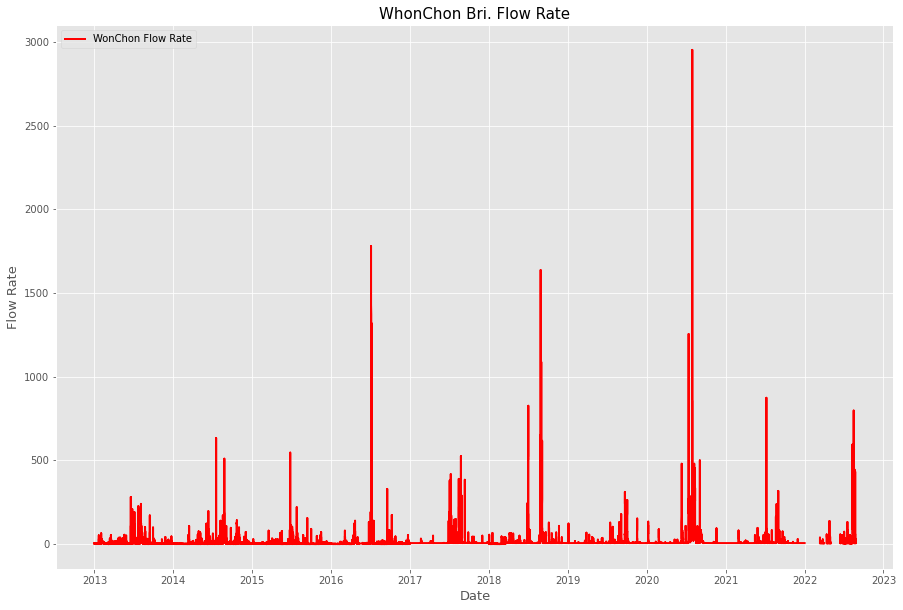

In [25]:
## 원촌교 유량 Data 시각화 -> 2022년 1월과 4월에 결측치가 많음을 볼 수 있음
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action = "ignore", category = SettingWithCopyWarning)
plt.style.use('ggplot')
# plt.rc('font', family = 'NanumBarunGothic')

data['date'] = pd.to_datetime(data['date'])

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot()

plt.plot(data['date'], data['fw_3009680'], label = 'WonChon Flow Rate', color = 'red', linewidth = 2)
plt.legend(loc = 'upper left')
plt.xlabel('Date', size = 13)
plt.ylabel('Flow Rate', size = 13)
plt.title("WhonChon Bri. Flow Rate", size = 15)
plt.show()

In [26]:
fw_3009680_mean = data['fw_3009680'].mean().round(2)        # 평균 값 구하기
data['fw_3009680'].fillna(fw_3009680_mean, inplace = True)  # 결측치 평균 값으로 대체
data.isnull().sum()

ymdhm          0
ecpc           0
inf            0
sfw            0
tototf         0
wl_3009675     0
fw_3009675     0
wl_3009673     0
fw_3009673     0
wl_3009665     0
fw_3009665     0
wl_3009693     0
fw_3009693     0
wl_3009670     0
fw_3009670     0
wl_3009680     0
fw_3009680     0
wl_3009640     0
fw_3009640     0
rf_30094040    0
rf_30094020    0
rf_30094050    0
datetime       0
date           0
year           0
month          0
day            0
dtype: int64

### 최종 File 저장

In [27]:
data.to_csv('./df.csv', index = False)  # 최종 Data 저장

In [28]:
df = pd.read_csv('./df.csv', index_col = 0)
df.head()

,ecpc,inf,sfw,tototf,wl_3009675,fw_3009675,wl_3009673,fw_3009673,wl_3009665,fw_3009665,...,wl_3009640,fw_3009640,rf_30094040,rf_30094020,rf_30094050,datetime,date,year,month,day
ymdhm,,,,,,,,,,,,,,,,,,,,,
201301010000,369.128,16.804,1039.41,11.087,0.24,8.08,1.02,1.79,1.84,2.65,...,0.77,0.24,0.0,0.0,0.0,2013-01-01 00:00:00,2013-01-01,2013,1,1
201301010010,369.128,11.443,1039.41,12.346,0.24,8.08,1.06,2.64,1.84,2.65,...,0.77,0.24,0.0,0.0,0.0,2013-01-01 00:10:00,2013-01-01,2013,1,1
201301010020,369.128,11.921,1039.41,12.330,0.24,8.08,1.06,2.64,1.84,2.65,...,0.77,0.24,0.0,0.0,0.0,2013-01-01 00:20:00,2013-01-01,2013,1,1
201301010030,369.128,12.328,1039.41,12.307,0.24,8.08,1.07,2.89,1.84,2.65,...,0.77,0.24,0.0,0.0,0.0,2013-01-01 00:30:00,2013-01-01,2013,1,1
201301010040,369.128,12.323,1039.41,12.331,0.24,8.08,1.07,2.89,1.84,2.65,...,0.77,0.24,0.0,0.0,0.0,2013-01-01 00:40:00,2013-01-01,2013,1,1
